In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import(
    load_excel, 
    load_odin_as_ml_dataset, 
    plot_confusion_matrix, 
    make_ml_dataset, 
    run_binary_regression, 
    transport_modes, 
    trip_motives, 
    province_codes, 
    transport_mode_col, 
    IGNORE_RULES, 
    apply_ignore_rules,
    number_of_sub_trips_col,
    )

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
years = [2019, 2021, 2022, 2023]
dfs = []
for year in years:
    odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
    if year in [2019, 2020]:
        odin_excel_path = odin_excel_path.replace("Databestand", "Databestand_v2.0")
    df = load_excel(odin_excel_path)
    # df = apply_ignore_rules(df, IGNORE_RULES)   # <<–– new line

    dfs.append(df[df[number_of_sub_trips_col] == 1])  # Filter for single sub-trips

df_all = pd.concat(dfs, ignore_index=True, join="inner")

Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV


In [3]:
df_all.columns

Index(['OP', 'OPID', 'Steekproef', 'Mode', 'HHPers', 'HHSam', 'HHPlOP',
       'HHLft1', 'HHLft2', 'HHLft3',
       ...
       'RReisduur', 'RReisduurBL', 'RVertStat', 'RAankStat', 'RTSamen',
       'RCorrSnelh', 'RVliegVer', 'FactorH', 'FactorP', 'FactorV'],
      dtype='object', length=202)

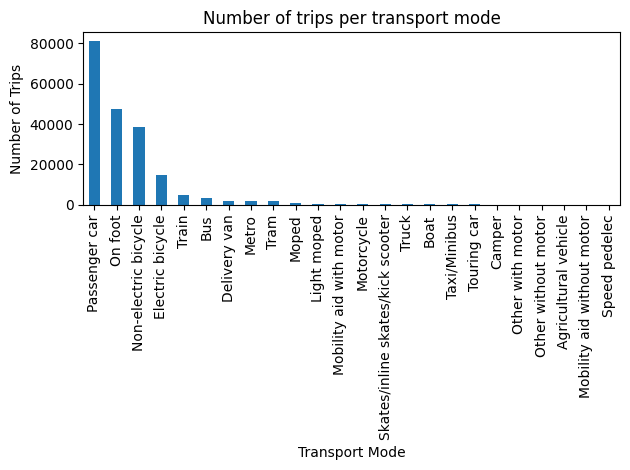

In [4]:
# Create a histogram for the number of trips for each transport mode and translate to 
ax = df[transport_mode_col].value_counts().plot(kind="bar", title="Number of trips per transport mode")

ax.set_xticklabels([transport_modes.get(int(float(label.get_text())), label.get_text()) for label in ax.get_xticklabels()], rotation=90)

plt.xlabel("Transport Mode")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

Now a classifier that classifies what mode of transport was used

Common labels: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23.]


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.7s finished


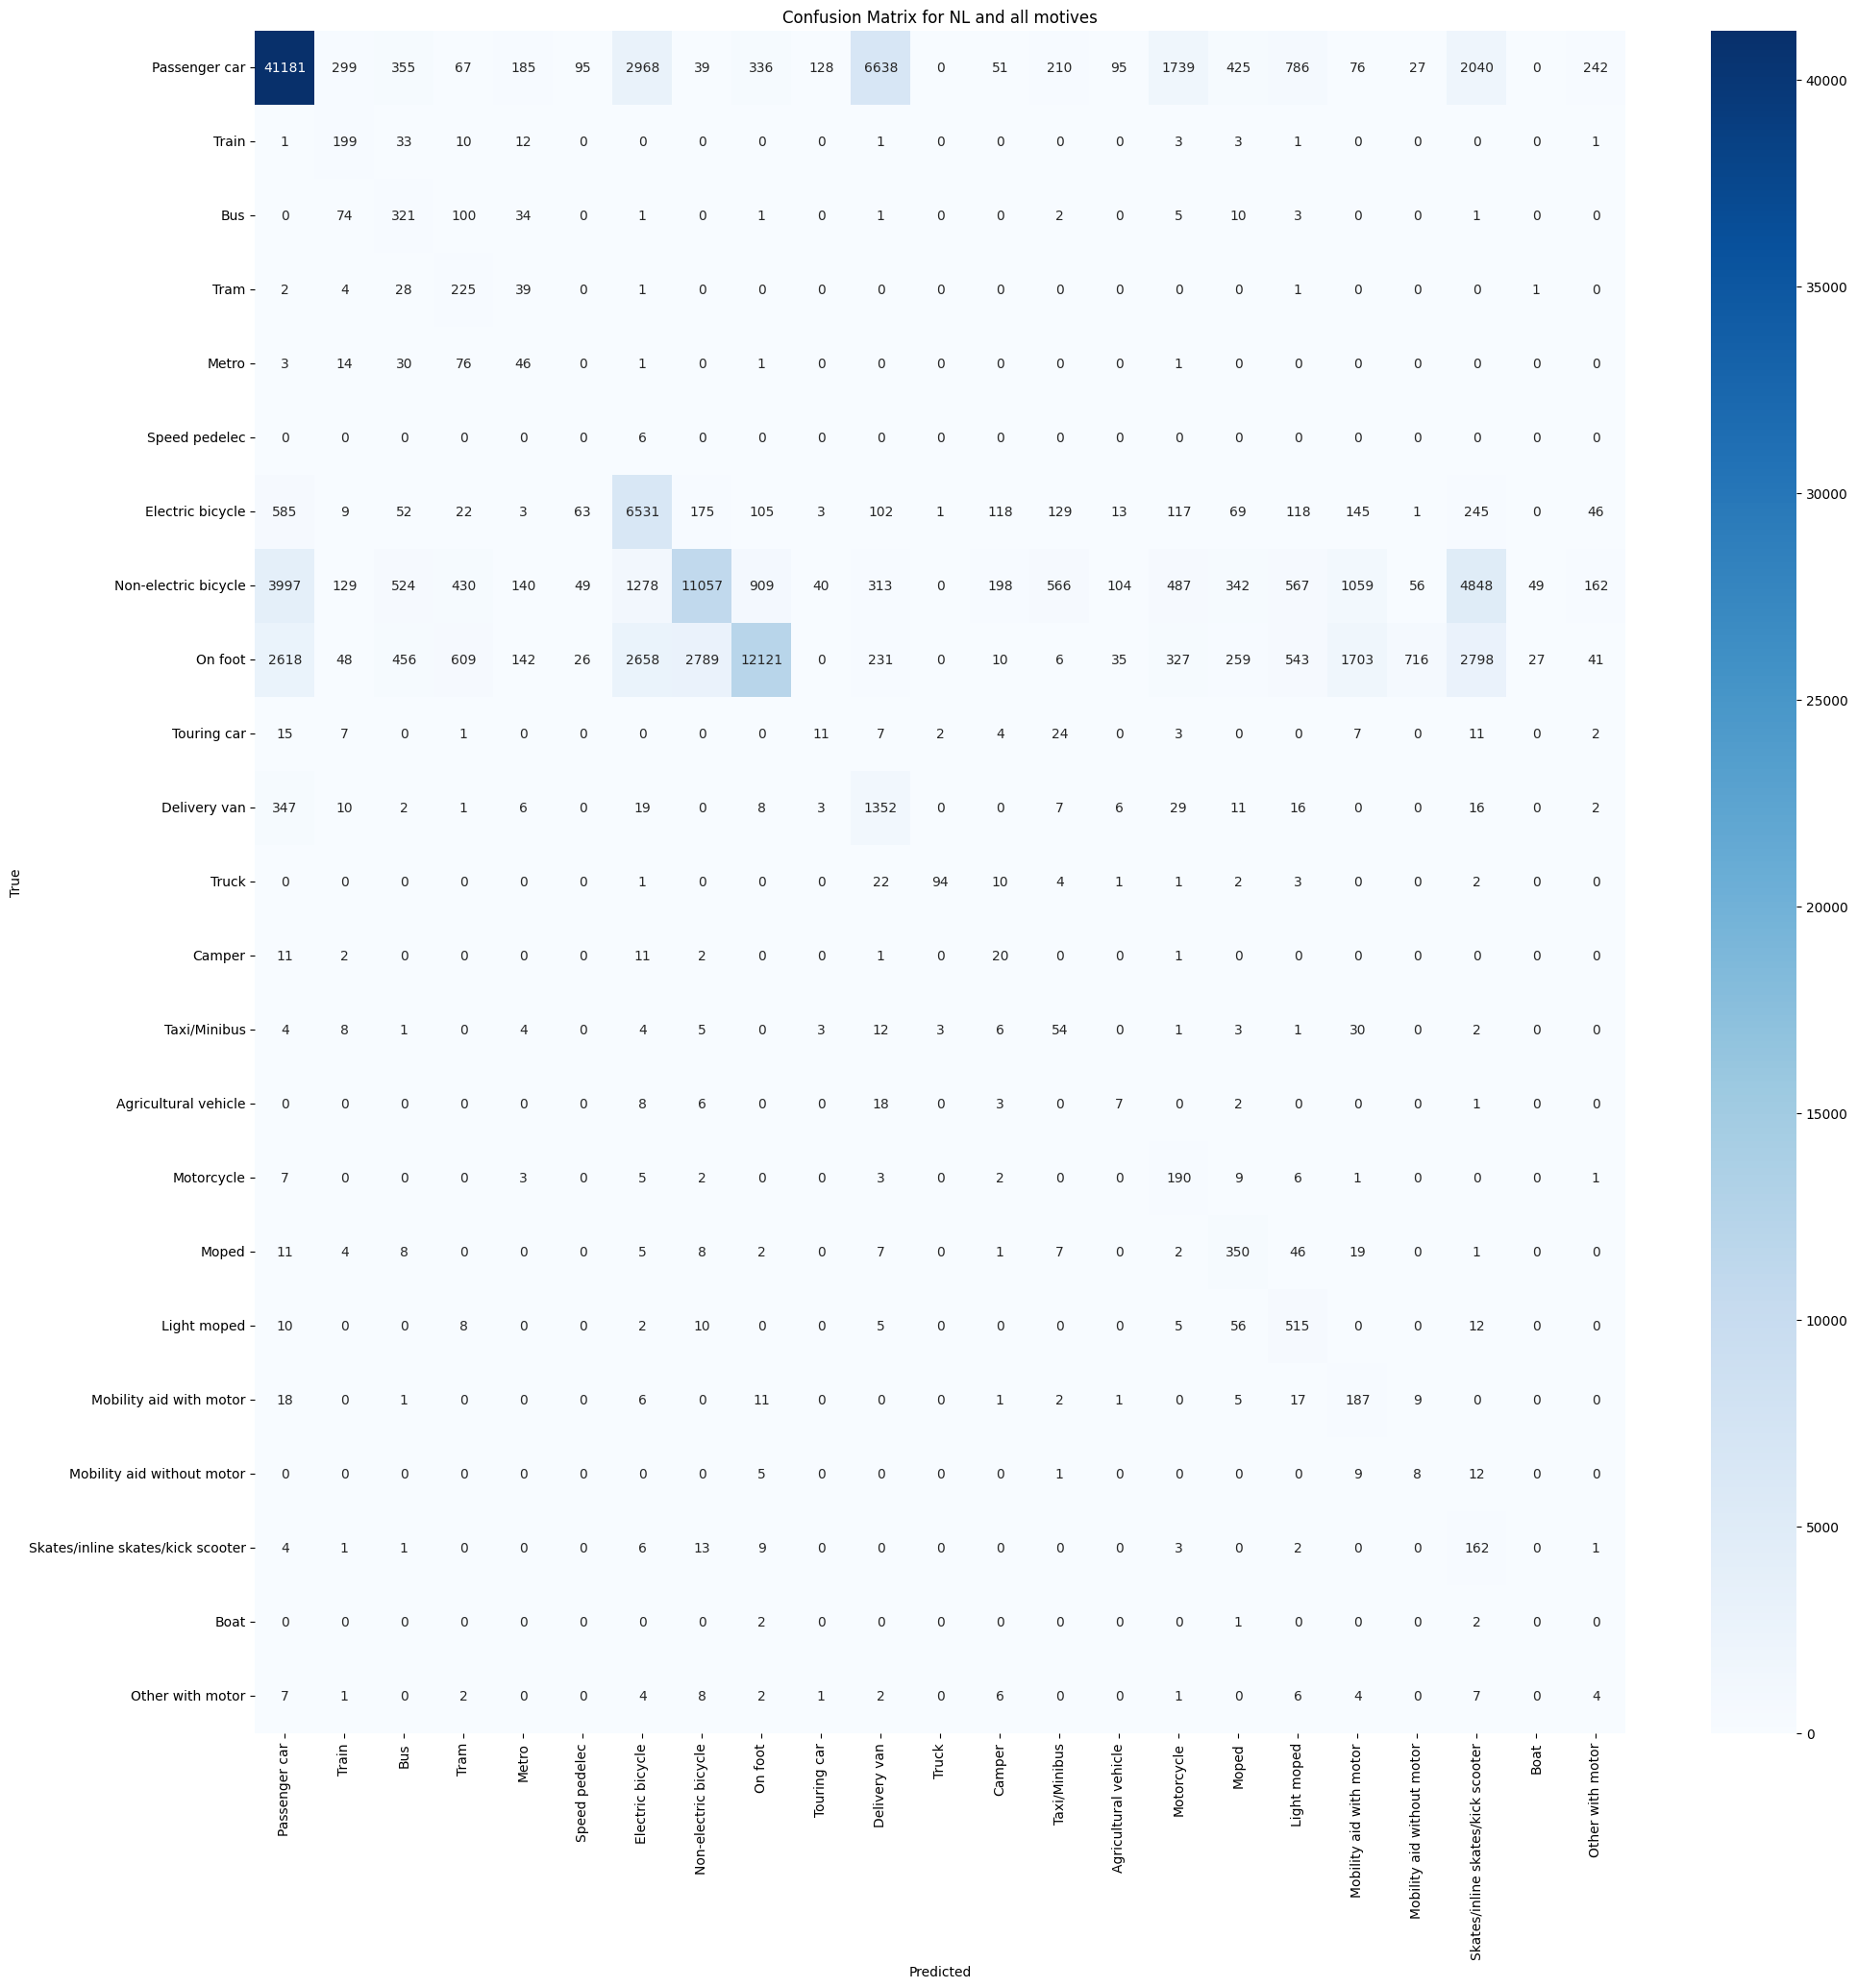

                                   precision    recall  f1-score   support

                    Passenger car       0.84      0.71      0.77     57982
                            Train       0.25      0.75      0.37       264
                              Bus       0.18      0.58      0.27       553
                             Tram       0.15      0.75      0.24       301
                            Metro       0.07      0.27      0.12       172
                    Speed pedelec       0.00      0.00      0.00         6
                 Electric bicycle       0.48      0.75      0.59      8652
             Non-electric bicycle       0.78      0.40      0.53     27304
                          On foot       0.90      0.43      0.58     28163
                      Touring car       0.06      0.12      0.08        94
                     Delivery van       0.16      0.74      0.26      1835
                            Truck       0.94      0.67      0.78       140
                        

In [5]:
from codebase import (run_multiclass_classification,
                      distance_col, 
                      origin_col, 
                      province_codes, 
                      level_mapping_suffix, 
                      age_col, 
                      transport_mode_col, 
                      motive_col, 
                      urbanness_col,
                      categorical_cols)

vehicles_to_include = [1, 7, 8, 9, ]

df_multiclass = df_all[df_all[transport_mode_col] != df_all[transport_mode_col].max()]
motives=None
origins=None#[7, 8, ]
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_all, (X_train, _, _, _) = run_multiclass_classification(
    df_multiclass,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/full",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
    verbose=True,
)

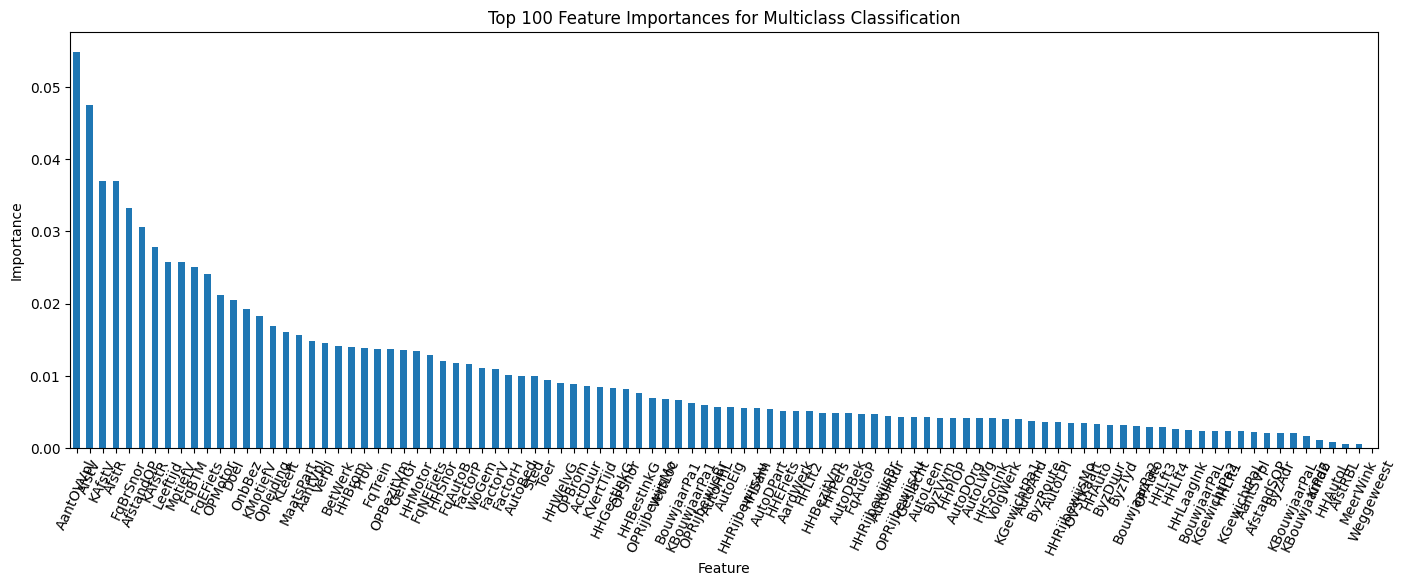

AantOVVpl     0.054872
AantSVpl      0.002184
AantVpl       0.014834
AardWerk      0.005133
ActDuur       0.008520
                ...   
Verpl         0.014487
VertLoc       0.006742
VolgWerk      0.004069
Weggeweest    0.000013
WoGem         0.011114
Length: 104, dtype: float64

In [6]:
def get_feature_importances(pipeline, column_names, top_n_for_plot=100, savename=None):
    importances = pd.Series(pipeline.steps[1][1].feature_importances_, index=column_names)
    
    # Group by base feature name (e.g., col_1 from col_1.0, col_1.1)
    grouped = importances.groupby(lambda x: x.split('_')[0]).sum()
    top_features = grouped.sort_values(ascending=False)[:top_n_for_plot]
    
    top_features.plot(kind="bar", figsize=(14, 6))
    plt.title(f"Top {top_n_for_plot} Feature Importances for Multiclass Classification")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.xticks(rotation=65)
    if savename:
        plt.savefig(savename)
    plt.show()
    
    return grouped

get_feature_importances(pipeline_all, column_names=X_train.columns, savename=f"graphics/classification_results/multiclass/feature_importances_all.png")

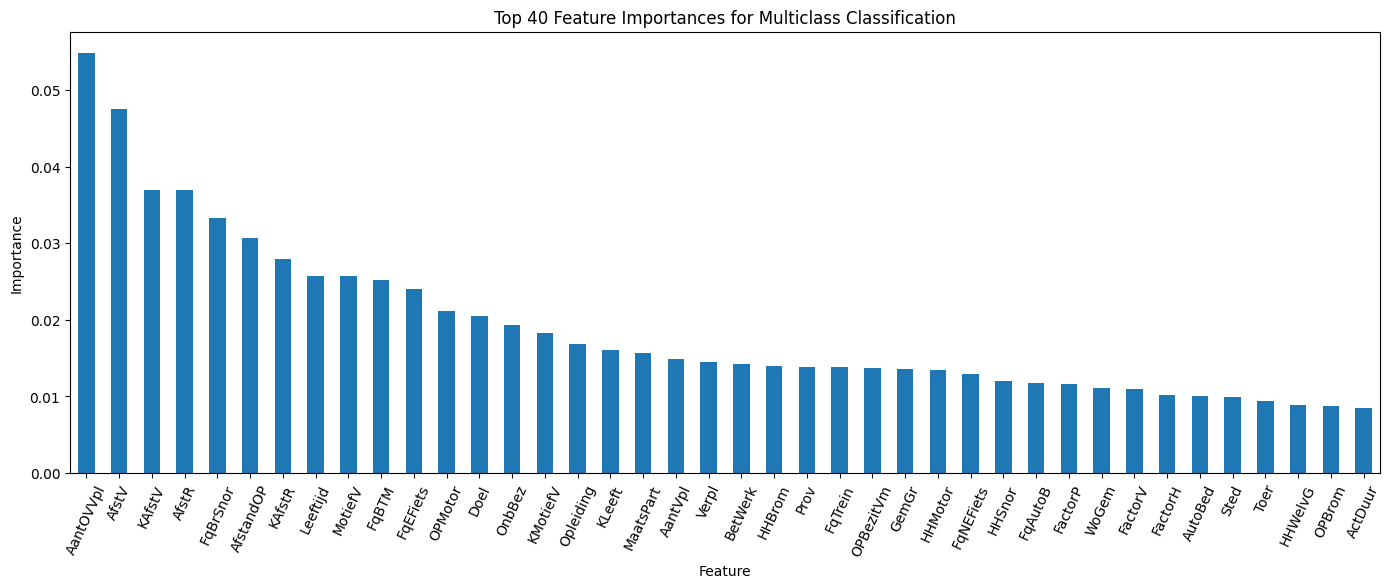

AantOVVpl     0.054872
AantSVpl      0.002184
AantVpl       0.014834
AardWerk      0.005133
ActDuur       0.008520
                ...   
Verpl         0.014487
VertLoc       0.006742
VolgWerk      0.004069
Weggeweest    0.000013
WoGem         0.011114
Length: 104, dtype: float64

In [7]:
get_feature_importances(pipeline_all, top_n_for_plot=40, column_names=X_train.columns, savename=f"graphics/classification_results/multiclass/feature_importances_all.png")

Common labels: [1. 7. 8. 9.]


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.2s finished


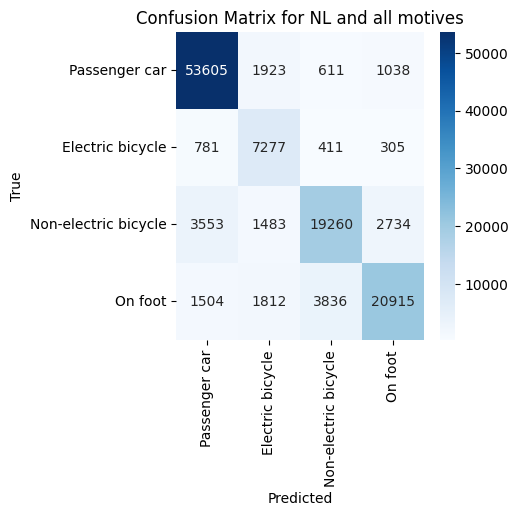

                      precision    recall  f1-score   support

       Passenger car       0.90      0.94      0.92     57177
    Electric bicycle       0.58      0.83      0.68      8774
Non-electric bicycle       0.80      0.71      0.75     27030
             On foot       0.84      0.75      0.79     28067

            accuracy                           0.83    121048
           macro avg       0.78      0.81      0.79    121048
        weighted avg       0.84      0.83      0.83    121048



In [8]:
from codebase import urbanness_col, motive_col

age_range = (0, np.inf)

df_less_vehicles = df_multiclass[df_multiclass[transport_mode_col].isin(vehicles_to_include)]
df_less_vehicles = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

vehicles_to_include = [1, 7, 8, 9, ]

motives=None
origins=None#[7, 8, ]
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_less, (X_train, _, _, _) = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

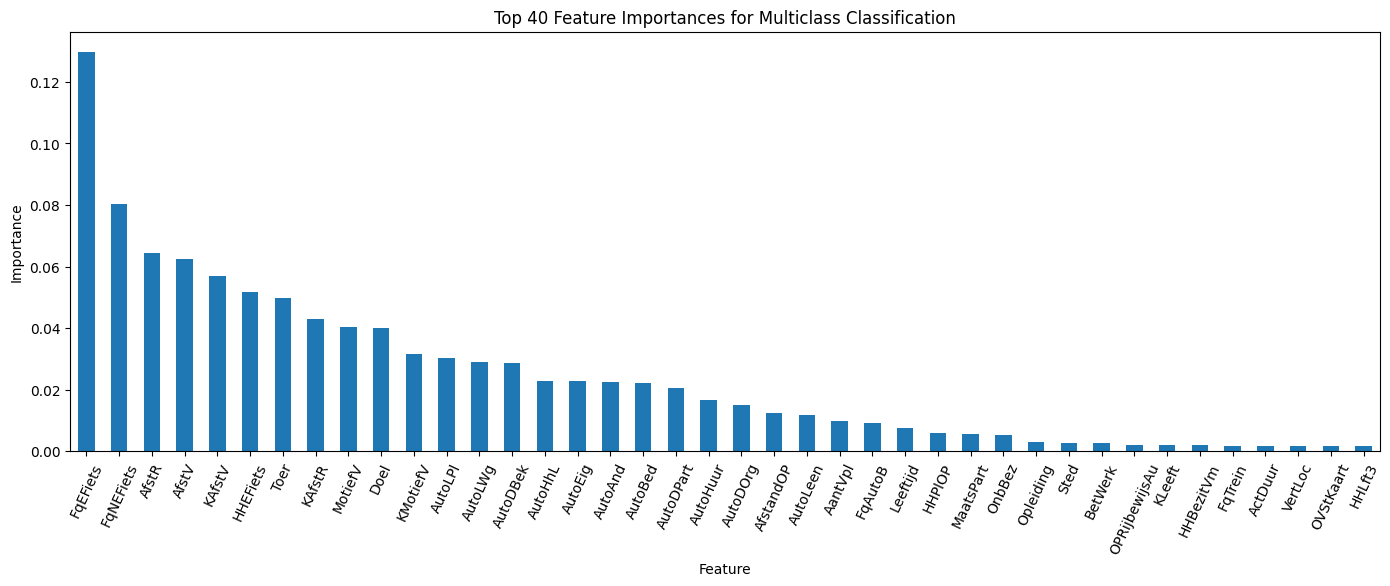

In [9]:
grouped_importances_less = get_feature_importances(pipeline_less, column_names=X_train.columns, top_n_for_plot=40, savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles.png")

Now keep the top 100

In [17]:
import numpy as np
import pandas as pd

from sklearn.calibration import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

from codebase.data.load_odin import make_ml_dataset
from codebase.data.filters import filter_by_distance_and_duration, filter_by_origin, filter_by_destination, filter_by_motive, transport_modes
from codebase.data.column_names import transport_mode_col, id_col
from codebase.plotting.plots import plot_confusion_matrix
from codebase.data.column_lists import (
    drop_cols, 
    numerical_cols,
    categorical_cols,
    ordinal_cols,
    binary_cols
)


def run_multiclass_classification(
        df: pd.DataFrame,
        model: BaseEstimator = None, 
        test_size=0.02, 
        max_dist=np.inf, 
        origins=None, 
        destinations=None,
        location_level=0,
        motives=None,
        categorical_features=categorical_cols,
        drop_cols=drop_cols,
        plot=True, 
        savename=None,
        verbose=True,
        plot_title="Multiclass Classification",
        ) -> tuple:
    """

    Run a binary regression on the dataset to predict the probability of specific mode based on distance.
    The model is trained on a subset of the data where the distance is less than max_dist and the duration is not filtered.
    The model is then evaluated on a test set and the predicted probabilities are plotted against the actual values.

    Parameters
    ----------
    df : pd.DataFrame
        The input dataframe containing the data.
    model : BaseEstimator, optional
        The machine learning model to use. Default is None, which uses RandomForestClassifier.
    transport_mode : int, optional
        The transport mode to predict. Default is 5 (Bicycle).
    test_size : float, optional
        The proportion of the dataset to include in the test split. Default is 0.02.
    max_dist : int, optional
        The maximum distance (in 100m) to filter the data. Default is 500.
    origins : list, optional
        A list of origins to filter the data. Default is None.
        If None, no filtering is applied.
    destinations : list, optional
        A list of destinations to filter the data. Default is None.
        If None, no filtering is applied.
    location_level : int, optional
        0: Buurt, 1: Gemeente, 2: Provincie, Default is 0.
    motives : list, optional
        A list of motives to filter the data. Default is None.
        If None, no filtering is applied.
    categorical_features : list, optional
        A list of categorical features to include in the model. Default is None.
    numerical_features : list, optional
        A list of numerical features to include in the model. Default is None.
    plot : bool, optional
        Whether to plot the predicted probabilities against the actual values. Default is True.
    savename : str, optional
        The name of the file to save the plot. If None, the plot will not be saved. Default is None.

    Returns
    -------
    tuple
        A tuple containing the trained model and the test set data (X_test, y_test, y_pred).
        X_train : pd.DataFrame
            The training set features.
        X_test : pd.DataFrame
            The test set features.
        y_test : pd.Series
            The actual values for the test set.
        y_pred : np.ndarray
            The predicted probabilities for the test set.
    """

    df_filtered = filter_by_origin(df, origins, level=location_level) if origins is not None else df
    df_filtered = filter_by_destination(df_filtered, destinations, level=location_level) if destinations else df_filtered
    df_filtered = filter_by_motive(df_filtered, motives) if motives else df_filtered
    try:
        df_filtered = filter_by_distance_and_duration(df_filtered, 0, max_dist, 0, np.inf)
    except KeyError as e:
        print(f"Skip filtering by distance and duration: {e}")
    
    X_train, X_test, y_train, y_test = make_ml_dataset(
        df_filtered,
        target_col=transport_mode_col,
        drop_cols=drop_cols,
        categorical_cols=categorical_features,
        test_size=test_size,
        group_col=id_col,
    )
    
    
    scaler = MinMaxScaler()
    model = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=10, n_estimators=100, class_weight="balanced", verbose=verbose) if model is None else model
    pipeline = make_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    if plot:
        transport_modes_plot = {k: v for k, v in transport_modes.items() if k in y_test.unique()}
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cm, labels=transport_modes_plot.values(), title=plot_title, savename=savename)

        print(classification_report(y_test, y_pred, target_names=transport_modes_plot.values()))

    return pipeline, (X_train, X_test, y_test, y_pred)

In [21]:
"Rvm" in df_less_vehicles.columns

True

Keeping 102 columns after dropping 100 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


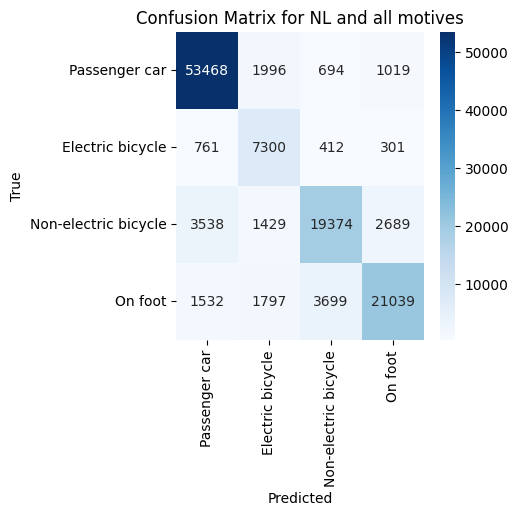

                      precision    recall  f1-score   support

       Passenger car       0.90      0.94      0.92     57177
    Electric bicycle       0.58      0.83      0.69      8774
Non-electric bicycle       0.80      0.72      0.76     27030
             On foot       0.84      0.75      0.79     28067

            accuracy                           0.84    121048
           macro avg       0.78      0.81      0.79    121048
        weighted avg       0.84      0.84      0.84    121048



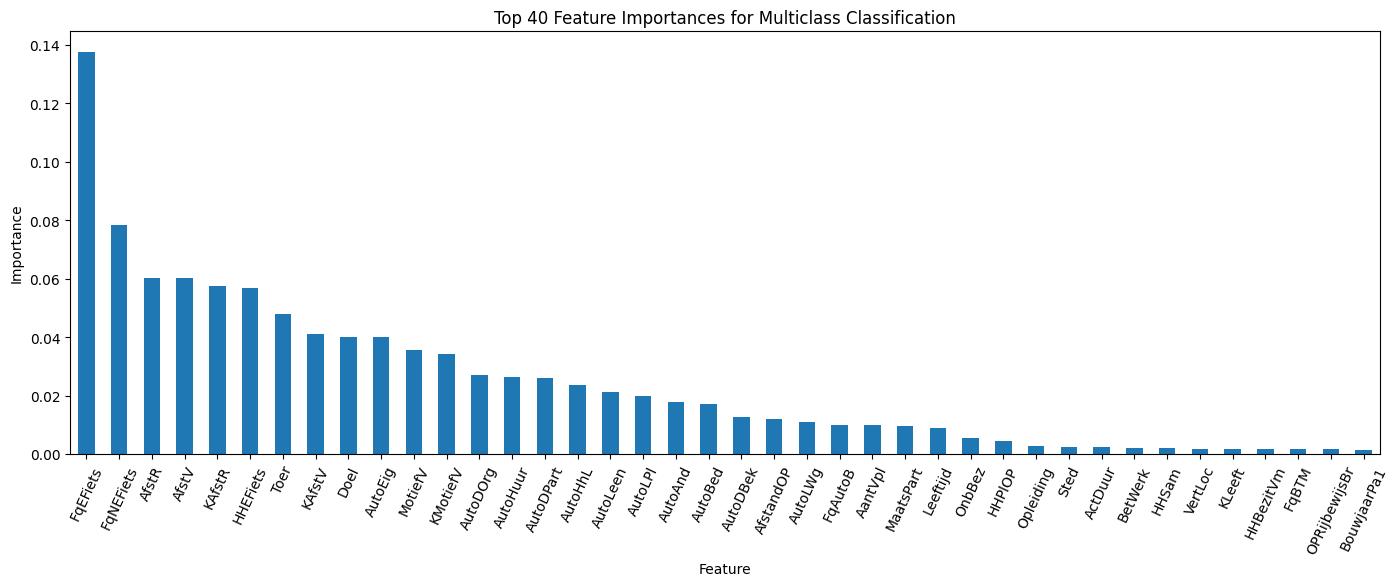

Keeping 52 columns after dropping 150 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


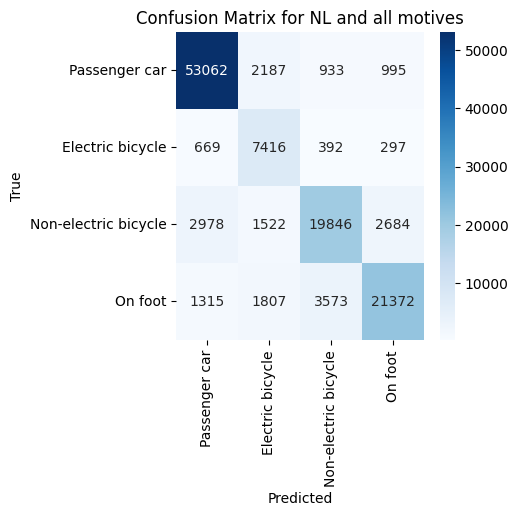

                      precision    recall  f1-score   support

       Passenger car       0.91      0.93      0.92     57177
    Electric bicycle       0.57      0.85      0.68      8774
Non-electric bicycle       0.80      0.73      0.77     27030
             On foot       0.84      0.76      0.80     28067

            accuracy                           0.84    121048
           macro avg       0.78      0.82      0.79    121048
        weighted avg       0.85      0.84      0.84    121048



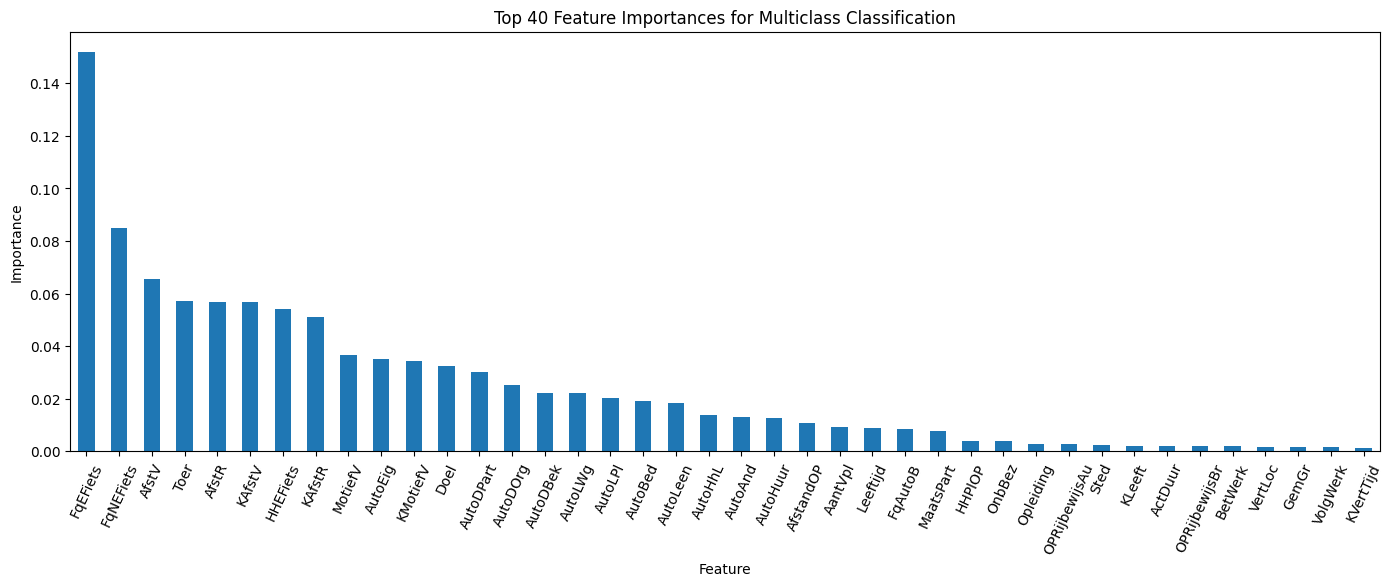

Keeping 27 columns after dropping 175 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


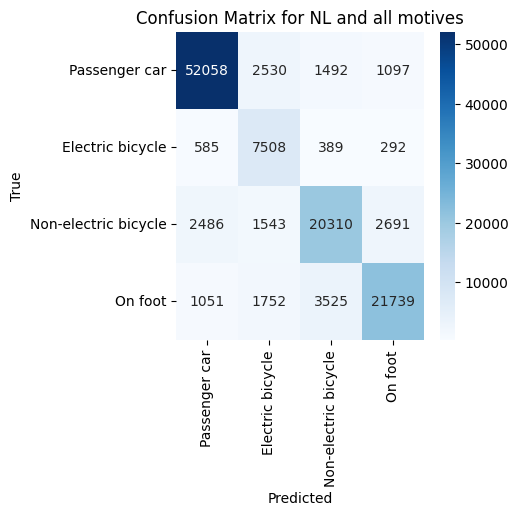

                      precision    recall  f1-score   support

       Passenger car       0.93      0.91      0.92     57177
    Electric bicycle       0.56      0.86      0.68      8774
Non-electric bicycle       0.79      0.75      0.77     27030
             On foot       0.84      0.77      0.81     28067

            accuracy                           0.84    121048
           macro avg       0.78      0.82      0.79    121048
        weighted avg       0.85      0.84      0.84    121048



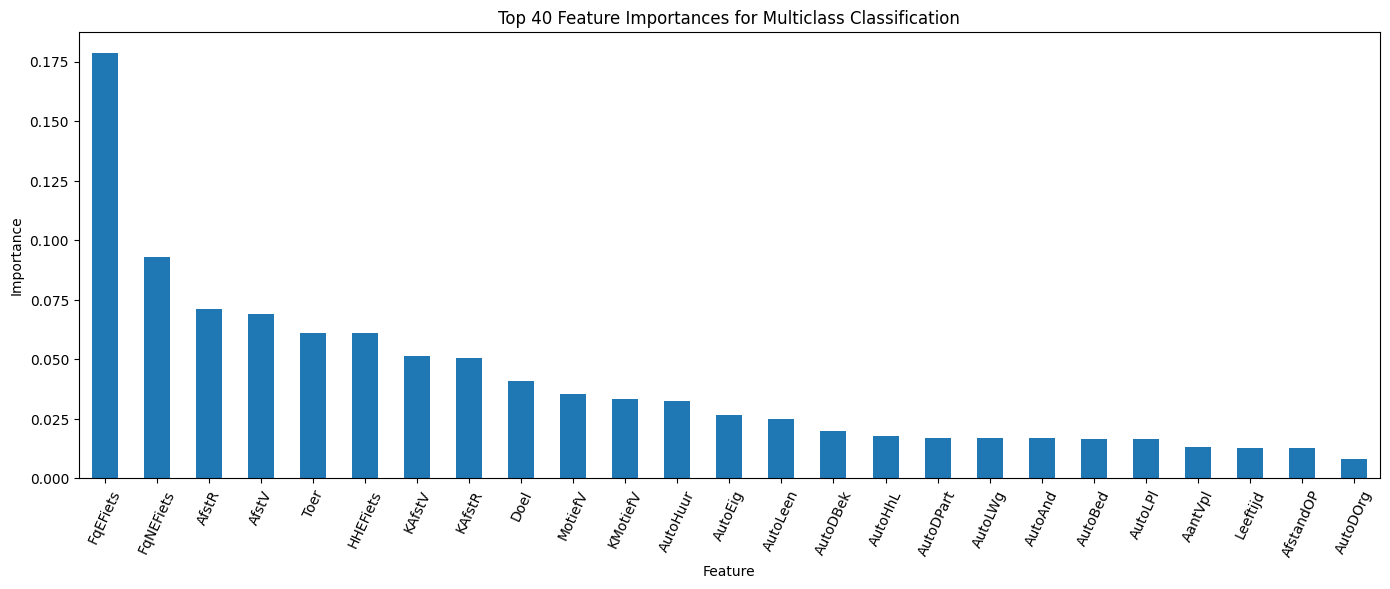

Keeping 12 columns after dropping 190 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


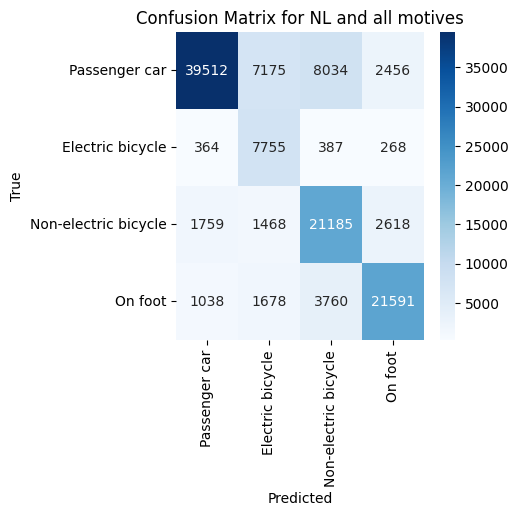

                      precision    recall  f1-score   support

       Passenger car       0.93      0.69      0.79     57177
    Electric bicycle       0.43      0.88      0.58      8774
Non-electric bicycle       0.63      0.78      0.70     27030
             On foot       0.80      0.77      0.79     28067

            accuracy                           0.74    121048
           macro avg       0.70      0.78      0.71    121048
        weighted avg       0.80      0.74      0.75    121048



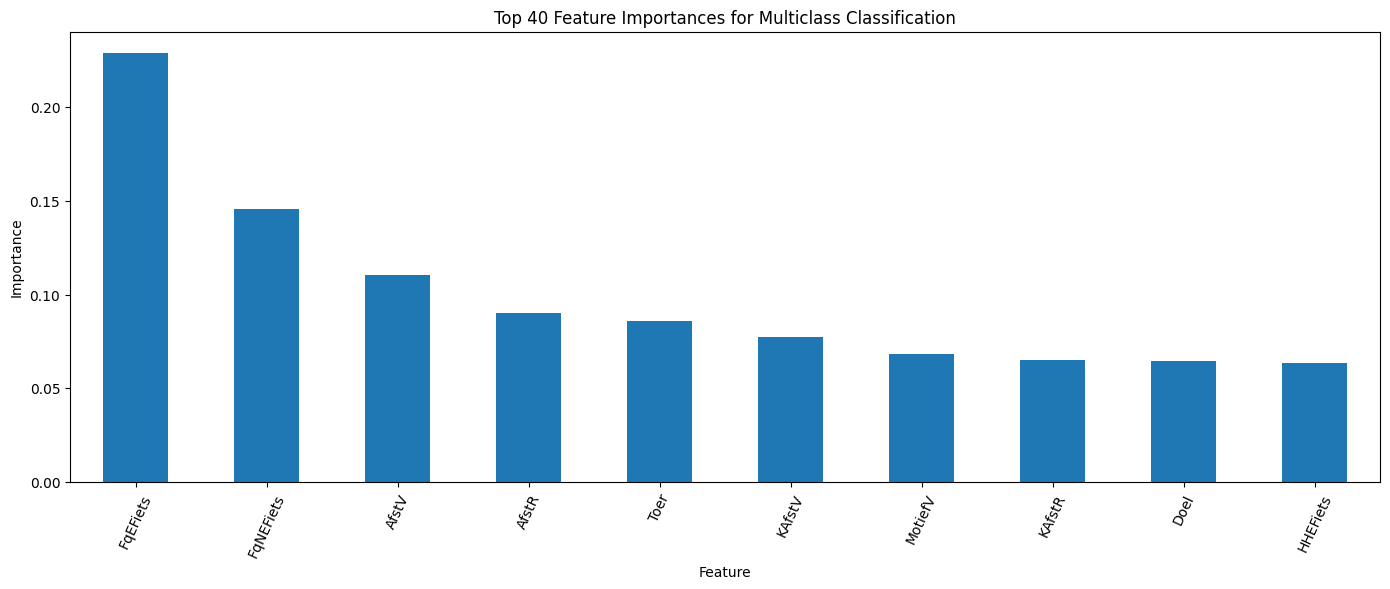

Keeping 7 columns after dropping 195 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


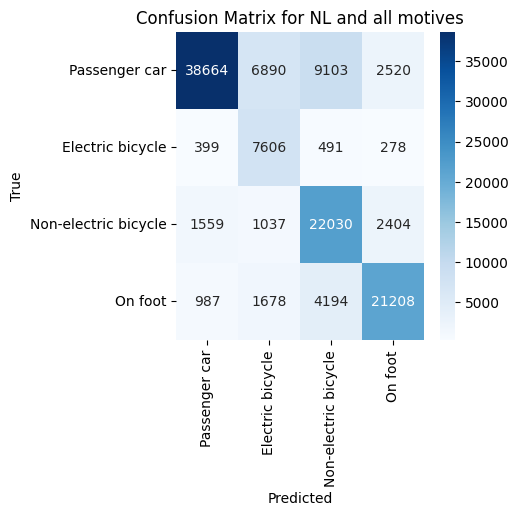

                      precision    recall  f1-score   support

       Passenger car       0.93      0.68      0.78     57177
    Electric bicycle       0.44      0.87      0.59      8774
Non-electric bicycle       0.62      0.82      0.70     27030
             On foot       0.80      0.76      0.78     28067

            accuracy                           0.74    121048
           macro avg       0.70      0.78      0.71    121048
        weighted avg       0.79      0.74      0.75    121048



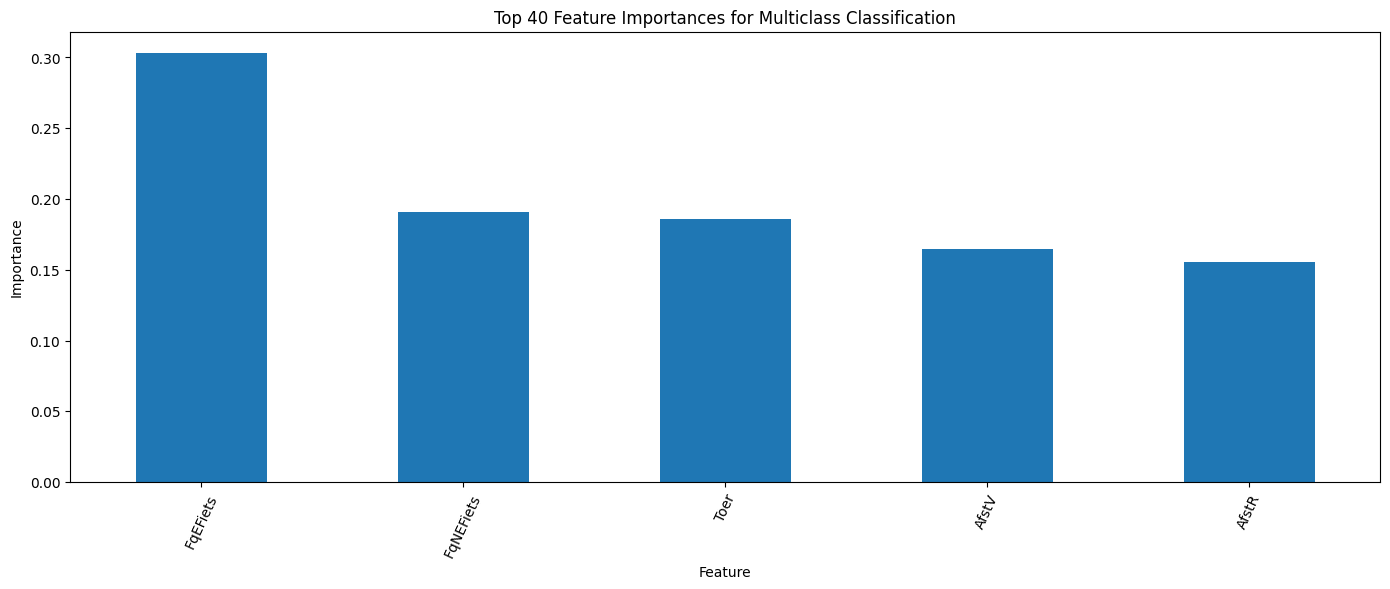

In [23]:
prev_grouped_importances = grouped_importances_less

for num_keep in [100, 50, 25, 10, 5]:
    prev_grouped_importances = prev_grouped_importances.sort_values(ascending=False)[:num_keep]

    cols_to_drop = [col for col in df_less_vehicles.columns if col not in list(prev_grouped_importances.index) + [transport_mode_col, id_col]]
    df_keep_loop = df_less_vehicles.drop(columns=cols_to_drop)
    print(f"Keeping {len(df_keep_loop.columns)} columns after dropping {len(cols_to_drop)} columns.")

    pipeline_keep_loop, (X_train, _, _, _) = run_multiclass_classification(
        df_keep_loop,
        test_size=0.2,
        destinations=None,
        origins=origins,
        location_level=location_level,
        categorical_features=categorical_cols,
        motives=motives,
        plot=True,
        savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles_{num_keep}",
        plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
    )

    prev_grouped_importances = get_feature_importances(
        pipeline_keep_loop, 
        column_names=X_train.columns, 
        top_n_for_plot=40, 
        savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles_{num_keep}.png"
    )

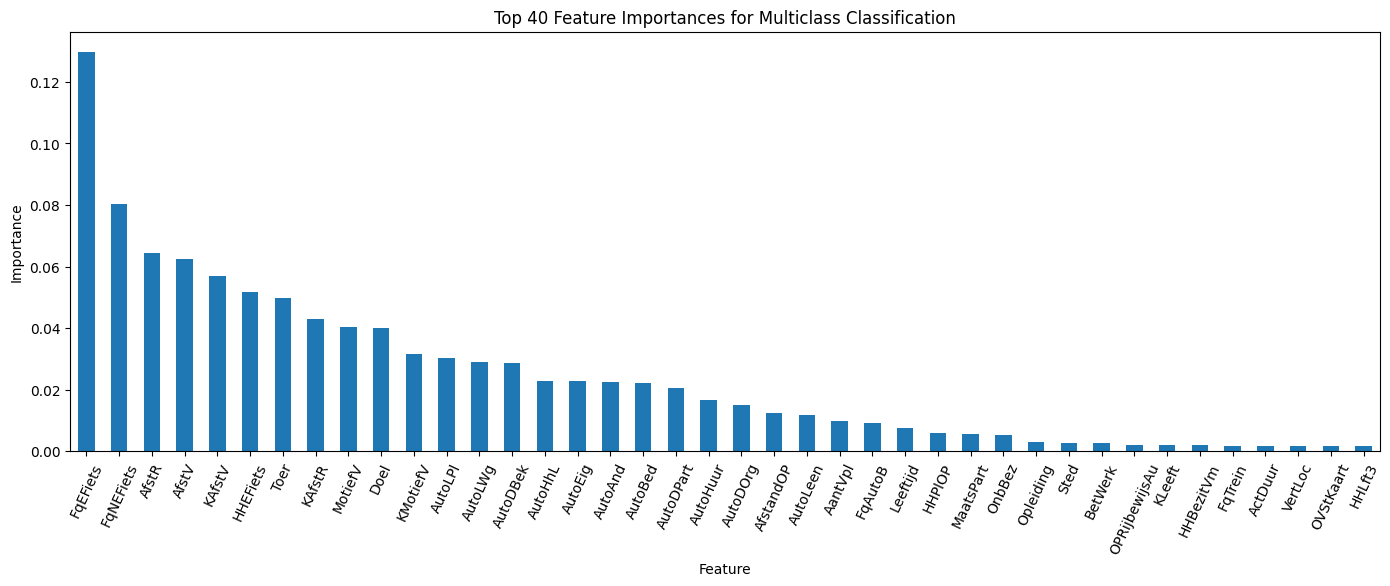

In [ ]:
importances_100 = get_feature_importances(pipeline_keep_loop, column_names=X_train.columns, top_n_for_plot=40, savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles_{num_keep}.png")

Now 50

Common labels: [1. 7. 8. 9.]


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


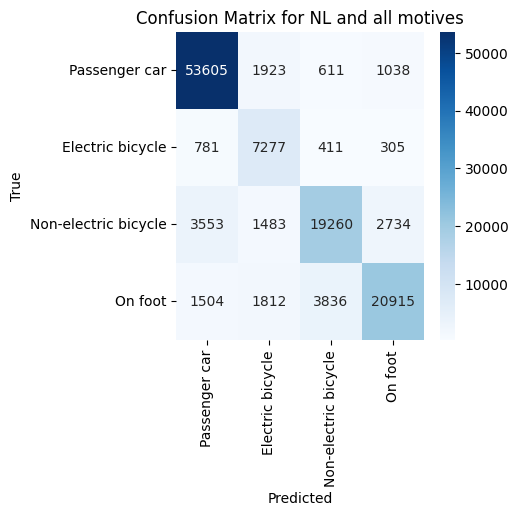

                      precision    recall  f1-score   support

       Passenger car       0.90      0.94      0.92     57177
    Electric bicycle       0.58      0.83      0.68      8774
Non-electric bicycle       0.80      0.71      0.75     27030
             On foot       0.84      0.75      0.79     28067

            accuracy                           0.83    121048
           macro avg       0.78      0.81      0.79    121048
        weighted avg       0.84      0.83      0.83    121048



In [ ]:
num_keep = 50
grouped_importances_less_100 = importances_100.sort_values(ascending=False)[:num_keep]

cols_to_drop = [col for col in X_train.columns if col.split('_')[0] not in importances_100.index]
df_less_50 = df_less_vehicles.drop(columns=cols_to_drop)

pipeline_less_50, (X_train, _, _, _) = run_multiclass_classification(
    df_less_50,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles_{num_keep}",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

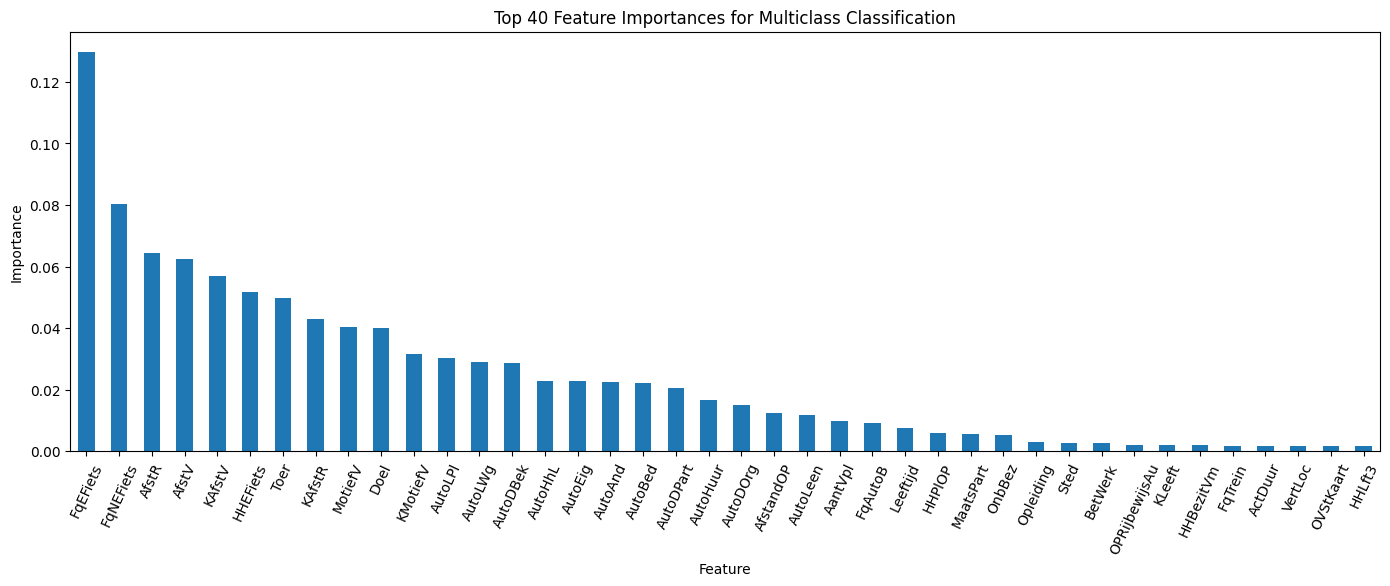

In [ ]:
importances_50 = get_feature_importances(pipeline_less_50, column_names=X_train.columns, top_n_for_plot=40, savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles_{num_keep}.png")

Common labels: [1. 7. 8. 9.]


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


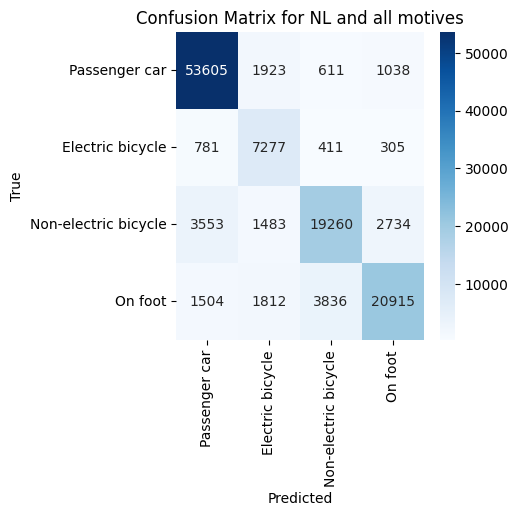

                      precision    recall  f1-score   support

       Passenger car       0.90      0.94      0.92     57177
    Electric bicycle       0.58      0.83      0.68      8774
Non-electric bicycle       0.80      0.71      0.75     27030
             On foot       0.84      0.75      0.79     28067

            accuracy                           0.83    121048
           macro avg       0.78      0.81      0.79    121048
        weighted avg       0.84      0.83      0.83    121048



In [ ]:
num_keep = 25
grouped_importances_less_25 = importances_50.sort_values(ascending=False)[:num_keep]

cols_to_drop = [col for col in X_train.columns if col.split('_')[0] not in importances_50.index]
df_less_25 = df_less_vehicles.drop(columns=cols_to_drop)

pipeline_less_25, (X_train, _, _, _) = run_multiclass_classification(
    df_less_25,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles_{num_keep}",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

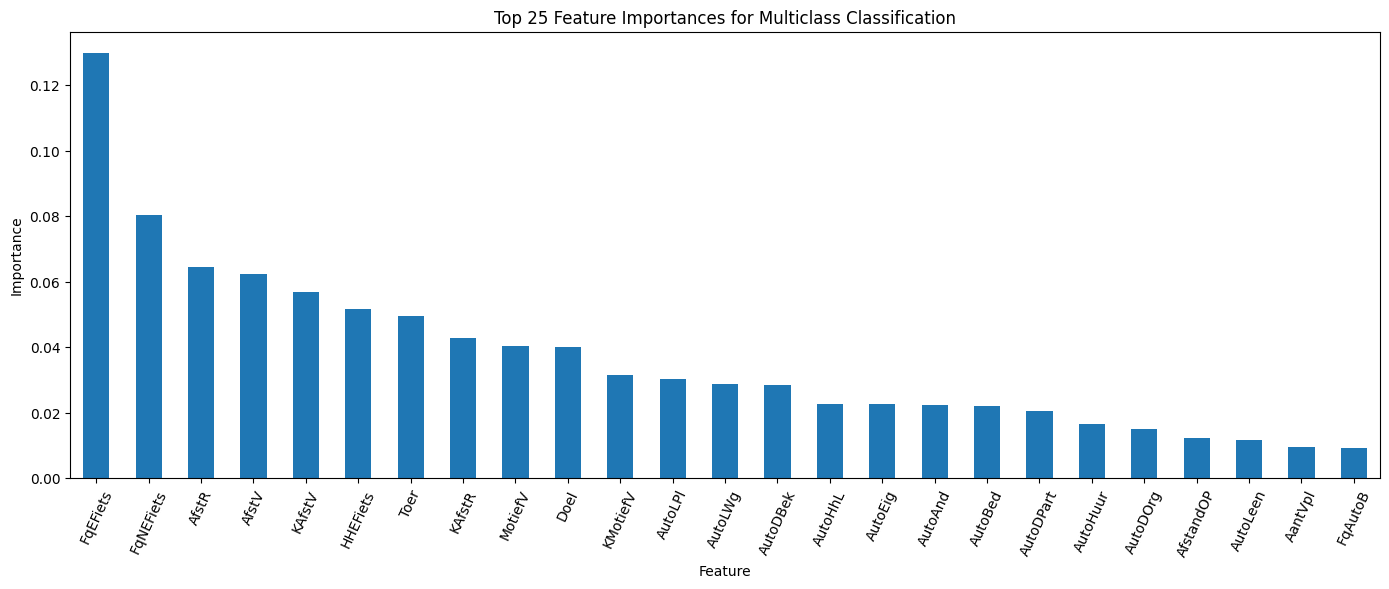

In [ ]:
importances_25 = get_feature_importances(pipeline_less_25, column_names=X_train.columns, top_n_for_plot=25, savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles_{num_keep}.png")

In [ ]:
len(importances_25)

102